In [15]:
# Copyright (c) OpenMMLab. All rights reserved.
import argparse
import os
import os.path as osp
import shutil
import time
import warnings

import mmcv
import torch
from mmcv.cnn.utils import revert_sync_batchnorm
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)
from mmcv.utils import DictAction
import pandas as pd
from mmseg import digit_version
from mmseg.apis import multi_gpu_test, single_gpu_test
from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from mmseg.utils import build_ddp, build_dp, get_device, setup_multi_processes
import albumentations as A

output_folder="/opt/ml/outputs/gaqoli29"
config_file=None
for file in os.listdir(output_folder):
    if file.endswith(".py"):
        config_file=os.path.join(output_folder, file)
        break
cfg = mmcv.Config.fromfile(config_file)

setup_multi_processes(cfg)

# if True:
#     # hard code index
#     cfg.data.test.pipeline[1].img_ratios = [
#         0.5, 0.75, 1.0, 1.25, 1.5, 1.75
#     ]
#     cfg.data.test.pipeline[1].flip = True
cfg.model.pretrained = None
cfg.data.test.test_mode = True

dataset = build_dataset(cfg.data.test)
loader_cfg = dict(
    num_gpus=len(cfg.gpu_ids),
    dist=False,
    shuffle=False)
loader_cfg.update({
    k: v
    for k, v in cfg.data.items() if k not in [
        'train', 'val', 'test', 'train_dataloader', 'val_dataloader',
        'test_dataloader'
    ]
})
test_loader_cfg = {
    **loader_cfg,
    'samples_per_gpu': 1,
    'shuffle': False,  # Not shuffle by default
    **cfg.data.get('test_dataloader', {})
}
cfg.checkpoint_config.meta = dict(
            config=cfg.pretty_text,
            CLASSES=dataset.CLASSES,
            PALETTE=dataset.PALETTE)


# build the dataloader
data_loader = build_dataloader(dataset, **test_loader_cfg)

# build the model and load checkpoint
cfg.model.train_cfg = None
model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
        
best_pth=None
for file in os.listdir(output_folder):
    if file.startswith("best"):
        best_pth=os.path.join(output_folder,file)
        break
checkpoint = load_checkpoint(model, best_pth, map_location='cuda')
'''if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    print('"CLASSES" not found in meta, use dataset.CLASSES instead')
    model.CLASSES = dataset.CLASSES
if 'PALETTE' in checkpoint.get('meta', {}):
    model.PALETTE = checkpoint['meta']['PALETTE']
else:
    print('"PALETTE" not found in meta, use dataset.PALETTE instead')
    model.PALETTE = dataset.PALETTE'''

# clean gpu memory when starting a new evaluation.
torch.cuda.empty_cache()
cfg.device = get_device()
model = revert_sync_batchnorm(model)
model = build_dp(model, cfg.device, device_ids=cfg.gpu_ids)
results = single_gpu_test(
    model,
    data_loader)

2023-01-02 05:34:44,971 - mmseg - INFO - Multi-processing start method is `None`
2023-01-02 05:34:44,974 - mmseg - INFO - OpenCV num_threads is `8
2023-01-02 05:34:44,979 - mmseg - INFO - Loaded 819 images
/opt/ml/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: /opt/ml/outputs/gaqoli29/best_mIoU_epoch_44.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 5.2 task/s, elapsed: 156s, ETA:     0s

In [31]:
new_visualization=[[0]*512 for _ in range(512)]
for i in range(512):
    for j in range(512):
        if results[0][i][j]==8:
            new_visualization[i][j]=1

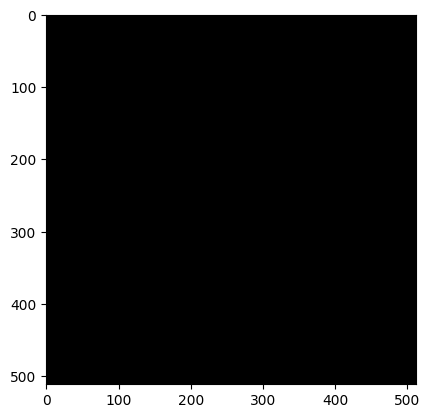

In [32]:
import matplotlib.pyplot as plt
plt.imshow(new_visualization, cmap=plt.cm.gray)  # use appropriate colormap here
plt.show()